In [0]:
import os
import shutil
from sklearn.utils import shuffle
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras import backend as K
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50, VGG19, InceptionResNetV2, InceptionV3, DenseNet201
from keras.applications.xception import Xception
from keras.callbacks import *
from keras.optimizers import Adam

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

Using TensorFlow backend.


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
main_folder = '/content/drive/My Drive/Colab Notebooks/playaround/visualization/images/'
files = os.listdir(main_folder)
!mkdir images
for f in files:
    shutil.copy2(main_folder + f, '/content/images/')

In [0]:
model2 = VGG16()
# print(model.summary())

W0701 05:36:44.723219 140294706304896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 05:36:44.778204 140294706304896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 05:36:44.788563 140294706304896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 05:36:44.850431 140294706304896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 5s 0us/step


W0701 05:36:51.526310 140294706304896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 05:36:51.527629 140294706304896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
def resize_to_height(img, size=224):
    scale1 = size / img.shape[0]
    scale2 = size / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale2, fy=scale1)

(512,) (14, 14, 512)


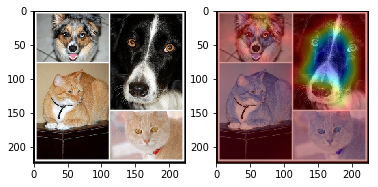

In [0]:
def showGradCAM1(model, path, idx, layer_name):
  # load image
    img = cv2.imread(path)
    img = resize_to_height(img)
    ogirin = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # convert to array
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # predict and get index of idx-th class
    preds = model.predict(x)
    top_n = preds[0].argsort()[-idx:][::-1]
    class_idx = top_n[idx-1]

    # conput gradient and pool
    layer_output = model.get_layer(layer_name).output
    output = model.output[:, class_idx]
    grads = K.gradients(output, layer_output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # create heatmap
    grad_function = K.function([model.input], [pooled_grads, layer_output[0]])  
    x_pooled_grads, x_layer_output = grad_function([x])  
    print(x_pooled_grads.shape, x_layer_output.shape)
    heatmap = np.dot(x_layer_output, x_pooled_grads)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # show result
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(ogirin)
    f.add_subplot(1,2, 2)
    plt.imshow(superimposed_img)
    plt.show(block=True)
  
showGradCAM1(model2,'./images/1_cat_dog.jpg',1, 'block5_conv3')

(?,)
(512,) (14, 14, 512)


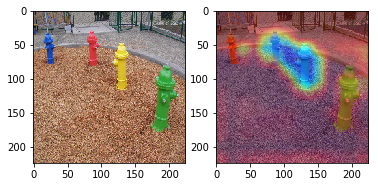

In [0]:
def showGradCAM2(model, path, idx, layer_name, resize=224):
    # load image
    img = cv2.imread(path)
    img = resize_to_height(img, resize)
    ogirin = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # convert to array
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # predict and get index of idx-th class
    preds = model.predict(x)
    top_n = preds[0].argsort()[-idx:][::-1]
    class_idx = top_n[idx-1]

    # conput gradient and pool
    layer_output = model.get_layer(layer_name).output
    output = model.output[:, class_idx]
    print(output.shape)
    grads = K.gradients(output, layer_output)[0]

    # create heatmap
    grad_function = K.function([model.input], [grads[0], layer_output[0]])  
    x_grads, x_layer_output = grad_function([x])  
    x_pooled_grads = np.mean(x_grads, axis=(0, 1))
    print(x_pooled_grads.shape, x_layer_output.shape)
    heatmap = np.dot(x_layer_output, x_pooled_grads)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # show result
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(ogirin)
    f.add_subplot(1,2, 2)
    plt.imshow(superimposed_img)
    plt.show(block=True)
  
showGradCAM2(model2,'./images/4_firehydrants.jpg', 1, 'block5_conv3')